In [1]:
import pyodbc
import cx_Oracle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
print('cx_Oracle: {}'.format(cx_Oracle.__version__))

cx_Oracle: 7.0.0


In [8]:
ip = ''
port = 
service_name = ''
dsn = cx_Oracle.makedsn(ip, port, service_name=service_name)
connection = cx_Oracle.connect('', '',dsn)
sql = """with grpbyday as
(select round(sum(seg_size) / 1024 / 1024 / 1024) ss, time_stamp dt
  from linchstat.segment$stat 
group by time_stamp)
select * from grpbyday 
order by dt
"""
data = pd.read_sql(sql,connection)
#data.head()

(array([736481., 736542., 736603., 736664., 736726., 736785., 736846.,
        736907., 736968.]), <a list of 9 Text xticklabel objects>)

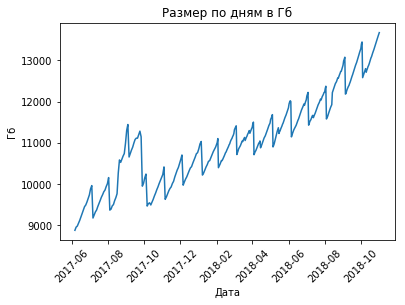

In [3]:
g=sns.lineplot(x='DT',y='SS',data=data)
g.set_title('Размер по дням в Гб')
g.set_ylabel('Гб')
g.set_xlabel('Дата')
plt.xticks(rotation=45)

In [4]:
sql = """with top_objects as
(select translate(NVL(SUBSTR(segment_name, 0, INSTR(segment_name, '$')-1), segment_name), 'a0123456789', 'a') table_name, sum(seg_size/1024/1024/1024) as summa, time_stamp 
from linchstat.segment$stat
where  trunc(cast(time_stamp as date)) = to_date('30.10.2018','DD.MM.YYYY')
group by translate(NVL(SUBSTR(segment_name, 0, INSTR(segment_name, '$')-1), segment_name), 'a0123456789', 'a'), time_stamp 
having sum(seg_size/1024/1024/1024)>50
 )

select translate(NVL(SUBSTR(segment_name, 0, INSTR(segment_name, '$')-1), segment_name), 'a0123456789', 'a') table_name, sum(seg_size/1024/1024/1024) as summa, time_stamp 
from linchstat.segment$stat
where  translate(NVL(SUBSTR(segment_name, 0, INSTR(segment_name, '$')-1), segment_name), 'a0123456789', 'a') in 
(select table_name from top_objects)
group by translate(NVL(SUBSTR(segment_name, 0, INSTR(segment_name, '$')-1), segment_name), 'a0123456789', 'a'), time_stamp 
order by time_stamp
"""
data = pd.read_sql(sql,connection)
#data.head()

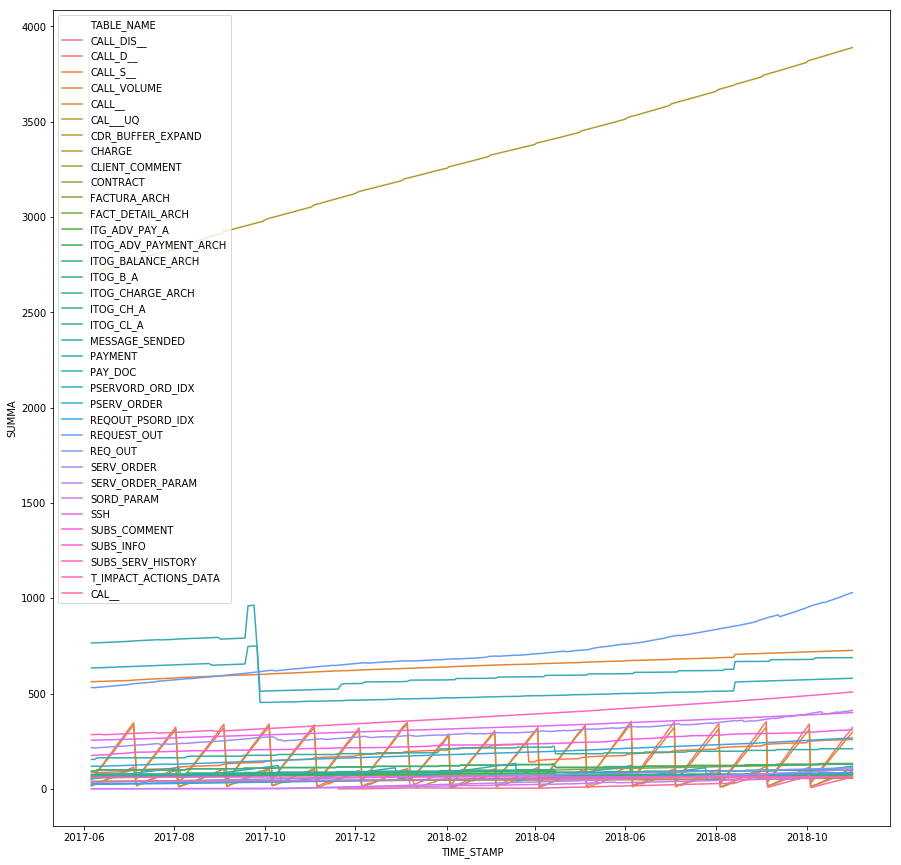

In [5]:
fig, ax = plt.subplots(figsize=(15,15))
sns.lineplot(ax=ax,x="TIME_STAMP", y="SUMMA", hue="TABLE_NAME", data=data)

In [6]:
sql = """with beg_objects as
(select translate(NVL(SUBSTR(segment_name, 0, INSTR(segment_name, '$')-1), segment_name), 'a0123456789', 'a') table_name, sum(seg_size/1024/1024/1024) as summa, time_stamp 
from linchstat.segment$stat
where  cast(time_stamp as date) = (select min(cast(time_stamp as date)) from linchstat.segment$stat)
group by translate(NVL(SUBSTR(segment_name, 0, INSTR(segment_name, '$')-1), segment_name), 'a0123456789', 'a'), time_stamp 
--having sum(seg_size/1024/1024/1024)>50
 ),end_objects as
(select translate(NVL(SUBSTR(segment_name, 0, INSTR(segment_name, '$')-1), segment_name), 'a0123456789', 'a') table_name, sum(seg_size/1024/1024/1024) as summa, time_stamp 
from linchstat.segment$stat
where  cast(time_stamp as date) = (select max(cast(time_stamp as date)) from linchstat.segment$stat)
group by translate(NVL(SUBSTR(segment_name, 0, INSTR(segment_name, '$')-1), segment_name), 'a0123456789', 'a'), time_stamp 
--having sum(seg_size/1024/1024/1024)>50
 )
select nvl(b.table_name,e.table_name) table_name, round(nvl(e.summa,0)- nvl(b.summa,0)) delta 
from beg_objects b left join end_objects e on b.table_name=e.table_name
where abs(nvl(e.summa,0)- nvl(b.summa,0))>10
order by delta desc
"""
data = pd.read_sql(sql,connection)
#data.head()

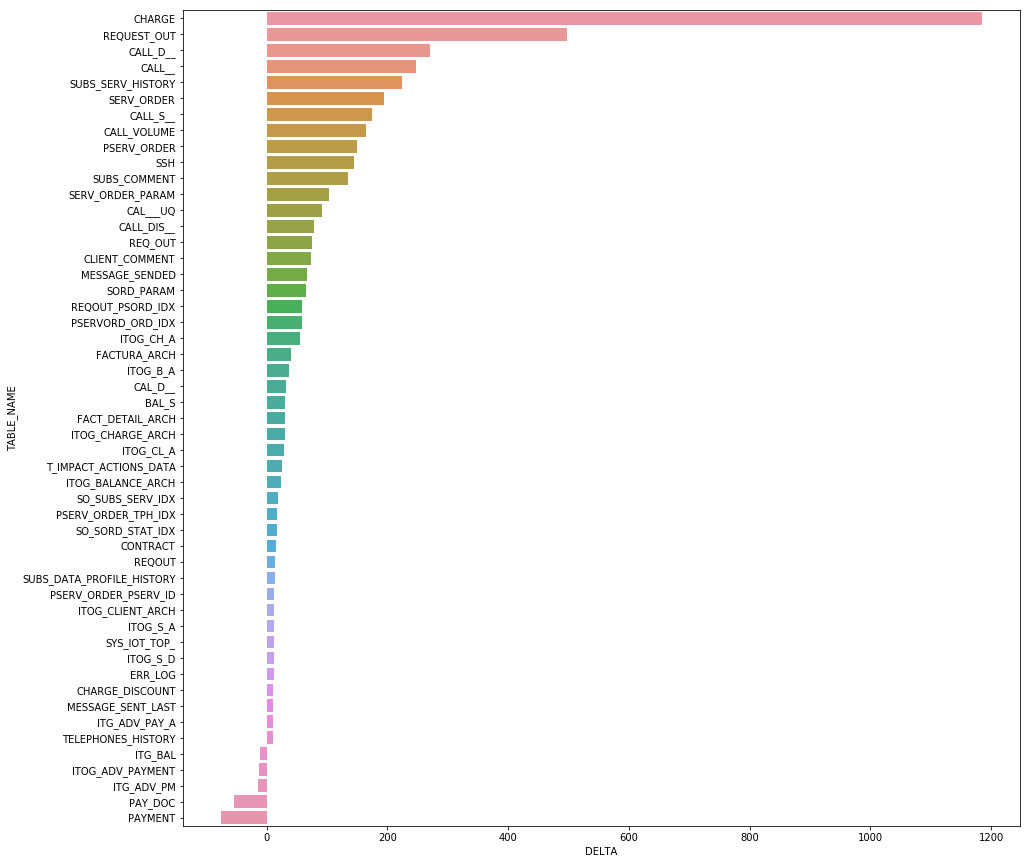

In [7]:
fig, ax = plt.subplots(figsize=(15,15))
sns.barplot(ax=ax,data=data, y="TABLE_NAME", x="DELTA", orient='h')